In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
nltk.download('punkt')
nltk.download('punkt_tab')

In [24]:
def extract_china_paragraph(file_path):
    keywords = ["China", "Chinese", "PRC"]
    chinese_cities = [
        "Beijing", "Shanghai", "Chongqing", "Tianjin", "Guangzhou",
        "Shenzhen", "Chengdu", "Wuhan", "Hangzhou", "Nanjing",
        "Xi'an", "Suzhou", "Zhengzhou", "Changsha", "Shenyang",
        "Qingdao", "Ningbo", "Kunming", "Wuxi", "Hefei",
        "Fuzhou", "Xiamen", "Harbin", "Jinan", "Dalian"
    ]
    keywords = keywords + chinese_cities
    results = []

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return []

    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    current_speaker = "Unknown"
    text_buffer = []

    def process_buffer(speaker, lines_buffer):
        # Filter out speakers with "Q -" tag
        if "Q -" in speaker:
            return []

        # Join lines and normalize whitespace
        text = " ".join(lines_buffer)
        text = " ".join(text.split())
        words = text.split()

        local_results = []
        for i, word in enumerate(words):
            if any(keyword in word for keyword in keywords):
                # Extract 10 words before and 10 words after
                start_index = max(0, i - 10)
                end_index = min(len(words), i + 11)

                block = " ".join(words[start_index:end_index])
                local_results.append((speaker, block))
        return local_results

    for line in lines:
        line = line.strip()
        if not line:
            continue

        # Check for speaker marker (line containing backtick)
        if '`' in line:
            # Process the text of the previous speaker
            if text_buffer:
                results.extend(process_buffer(current_speaker, text_buffer))
                text_buffer = []

            # Update speaker (remove the backtick)
            current_speaker = line.replace('`', '').strip()
        else:
            text_buffer.append(line)

    # Process the last buffer
    if text_buffer:
        results.extend(process_buffer(current_speaker, text_buffer))

    return results

# Test with the file defined in the 'txt' variable
results = extract_china_paragraph(txt)

In [28]:
results

[('A - Jen-Hsun Huang',
  'market in Latin America is growing, the gaming market in China continues to grow even through a slower economy. People are'),
 ('A - Jen-Hsun Huang',
  'shy of 40% of our total gaming business is in China. The Chinese market is surprisingly resilient, because most of the'),
 ('A - Jen-Hsun Huang',
  '40% of our total gaming business is in China. The Chinese market is surprisingly resilient, because most of the games are'),
 ('A - Jen-Hsun Huang',
  'One of the reasons why Tencent grew so fast in China. Once the social network gets traction, it grows faster than'),
 ('A - Jen-Hsun Huang',
  "faster than linear. And so, there's some reasons why the Chinese market is more resilient, the gaming market is more resilient"),
 ('A - Jen-Hsun Huang',
  "We're also seeing a shift to higher end GPUs in China. Some of that probably has to do with the dramatic"),
 ('A - Jen-Hsun Huang',
  'dramatic change in improvement in production value of games in China. There was a t

In [29]:
def load_sentiment_dictionary(filepath, as_dict=False):
    df = pd.read_csv(filepath)
    df['Word'] = df['Word'].astype(str)

    sentiment_cols = [
        'Negative', 'Positive', 'Uncertainty', 'Litigious',
        'Strong_Modal', 'Weak_Modal', 'Constraining'
    ]

    for col in sentiment_cols:
        df[col] = df[col] > 0

    if as_dict:
        df.set_index('Word', inplace=True)
        return df[sentiment_cols].to_dict(orient='index')

    return df

lm_df = load_sentiment_dictionary()

positive_set = set(lm_df[lm_df['Positive'] == True]['Word'])
negative_set = set(lm_df[lm_df['Negative'] == True]['Word'])

In [26]:
def generate_bigrams(cleaned_text):
    # Tokenize using NLTK's word tokenizer
    tokens = word_tokenize(cleaned_text)

    # Generate bigrams using NLTK's utility
    return list(bigrams(tokens))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [27]:
def score_bigram(bigram, positive_set, negative_set):
    word1, word2 = bigram
    word1, word2 = word1.upper(), word2.upper()

    if word1 in positive_set or word2 in positive_set:
        return 1

    if word1 in negative_set or word2 in negative_set:
        return -1

    return 0


def calculate_transcript_sentiment(bigrams_list, positive_set, negative_set):
    net_score = 0
    pos_count = 0
    neg_count = 0

    for bigram in bigrams_list:
        score = score_bigram(bigram, positive_set, negative_set)

        if score == 1:
            pos_count += 1
            net_score += 1
        elif score == -1:
            neg_count += 1
            net_score -= 1

    total_bigrams = len(bigrams_list)
    proportional_sentiment = net_score / total_bigrams if total_bigrams > 0 else 0.0

    return {
        "net_sentiment": net_score,
        "proportional_sentiment": proportional_sentiment if abs(proportional_sentiment) < 0.8 else 0,
        "positive_bigrams": pos_count,
        "negative_bigrams": neg_count,
        "total_bigrams": total_bigrams
    }

In [65]:
search_dir = '\overseas-project-week-1\earnings-call-text'
txt_files = []

for root, dirs, files in os.walk(search_dir):
    for file in files:
        txt_files.append(os.path.join(root, file))

In [35]:
def get_clean_filename(filename):
    clean_name = (filename.split("/")[-1]).split("-_Earnings_Call")[0]
    return clean_name + ".txt"

In [104]:
def map_company_to_industry(company_name):
    industry_mapping = {
        'Pfizer': 'Healthcare',
        'AstraZeneca': 'Healthcare',
        'Novartis': 'Healthcare',
        'Toyota': 'Autos',
        'BMW': 'Autos',
        'Tesla': 'Autos',
        'Microsoft': 'Tech',
        'SAP': 'Tech',
        'NVIDIA': 'Tech'
    }
    return industry_mapping.get(company_name, 'Other')

In [47]:
def convert_to_quarter(date_str):
    date_str = str(date_str).strip()

    year = date_str[:4]
    month = int(date_str[4:6])

    quarter = (month - 1) // 3 + 1

    return f"{year}Q{quarter}"

In [125]:
company_data = []
speaker_data = []

for txt in txt_files:
    split = (get_clean_filename(txt).split(".")[0]).split("_")

    date = split[0]
    company = split[1]
    if company == "Bayerische":
        company = "BMW"
    quarter = convert_to_quarter(date)
    results = extract_china_paragraph(txt)

    proportional_scores = []

    for i, block in enumerate(results, 1):
        speaker = block[0]
        if speaker == "Unknown":
            speaker = "CEO"
        source = "Earnings Call"
        if "A -" in speaker:
            speaker = speaker.strip("A - ")
            source = "Q&A"
        bigrams_list = generate_bigrams(block[1])
        sentiment_results = calculate_transcript_sentiment(bigrams_list, positive_set, negative_set)

        speaker_data.append({
            "company": company,
            "speaker": speaker,
            "quarter": quarter,
            "source": source,
            "quote": block[1],
            "sentiment": sentiment_results['proportional_sentiment'],
            "interpretation": "Very Positive" if sentiment_results['proportional_sentiment'] > 0.1 else ( "Positive" if sentiment_results['proportional_sentiment'] > 0 else ( "Neutral" if sentiment_results['proportional_sentiment'] == 0 else ( "Very Negative" if sentiment_results['proportional_sentiment'] < -0.1 else "Negative" ) ) )
        })

        # if (sentiment_results['net_sentiment'] != 0):
        proportional_scores.append(sentiment_results['proportional_sentiment'])

    if proportional_scores:
        average_score = sum(proportional_scores) / len(proportional_scores)
    else:
        average_score = 0

    company_data.append({
        "company": company,
        "quarter": quarter,
        "avgsentiment": average_score
    })

df_data = pd.DataFrame(speaker_data)
df_sentiment = pd.DataFrame(company_data)
df_sentiment['industry'] = df_sentiment['company'].apply(map_company_to_industry)

In [135]:
df_data.sort_values(by="quarter").to_excel("./df_data.xlsx", index=False)

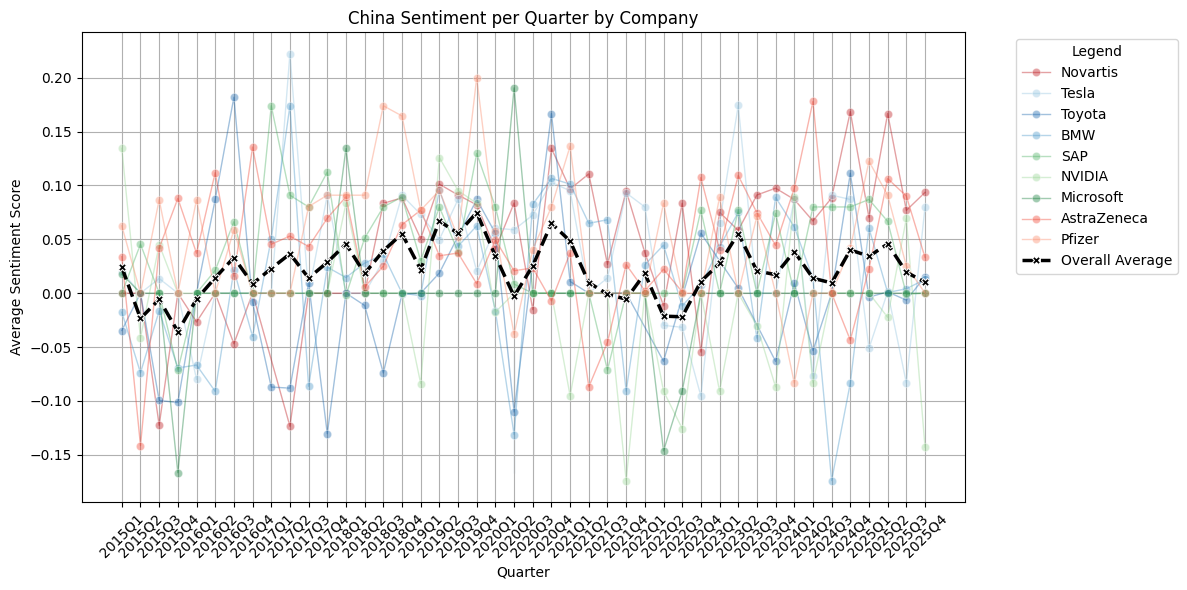

In [116]:
# Define the industry base color palettes
industry_palettes = {
    'Autos': 'Blues',
    'Healthcare': 'Reds',
    'Tech': 'Greens'
}

company_color_map = {}

# Group companies by their industry to assign sequential shades
# Using the original df_sentiment to ensure all companies are captured
industry_company_groups = df_sentiment.groupby('industry')['company'].unique()

for industry, companies_in_industry in industry_company_groups.items():
    if industry in industry_palettes:
        palette_name = industry_palettes[industry]
        num_companies = len(companies_in_industry)

        # Generate a color palette with enough distinct shades
        # Using num_companies + 1 and slicing [1:] to avoid the lightest shade if desired,
        # or simply num_companies if a wider range is needed.
        # Ensuring at least 2 shades if there's only one company to make the palette generation consistent
        colors = sns.color_palette(palette_name, n_colors=max(num_companies + 1, 3))[1:]

        for i, company in enumerate(companies_in_industry):
            company_color_map[company] = colors[i]
    else:
        # Handle 'Other' category or unmapped industries
        for company in companies_in_industry:
            company_color_map[company] = 'gray' # Default for 'Other'

# Sort the DataFrame by quarter to ensure the x-axis is in chronological order
df_sentiment_sorted = df_sentiment.sort_values('quarter')

# Calculate the average sentiment across all companies for each quarter
average_trend = df_sentiment_sorted.groupby('quarter')['avgsentiment'].mean().reset_index()

plt.figure(figsize=(12, 6))

# Plot individual company lines with transparency, using the new color map
sns.lineplot(data=df_sentiment_sorted, x='quarter', y='avgsentiment', hue='company', marker='o', alpha=0.4, palette=company_color_map, linewidth=1)

# Plot the overall average trendline
# We use a distinct color (black) and style (dashed) to distinguish it
sns.lineplot(data=average_trend, x='quarter', y='avgsentiment',
             color='black', linestyle='--', linewidth=2.5, label='Overall Average', marker='X')

plt.title('China Sentiment per Quarter by Company')
plt.xlabel('Quarter')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)

# Update legend to include the new line and move it outside the plot
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

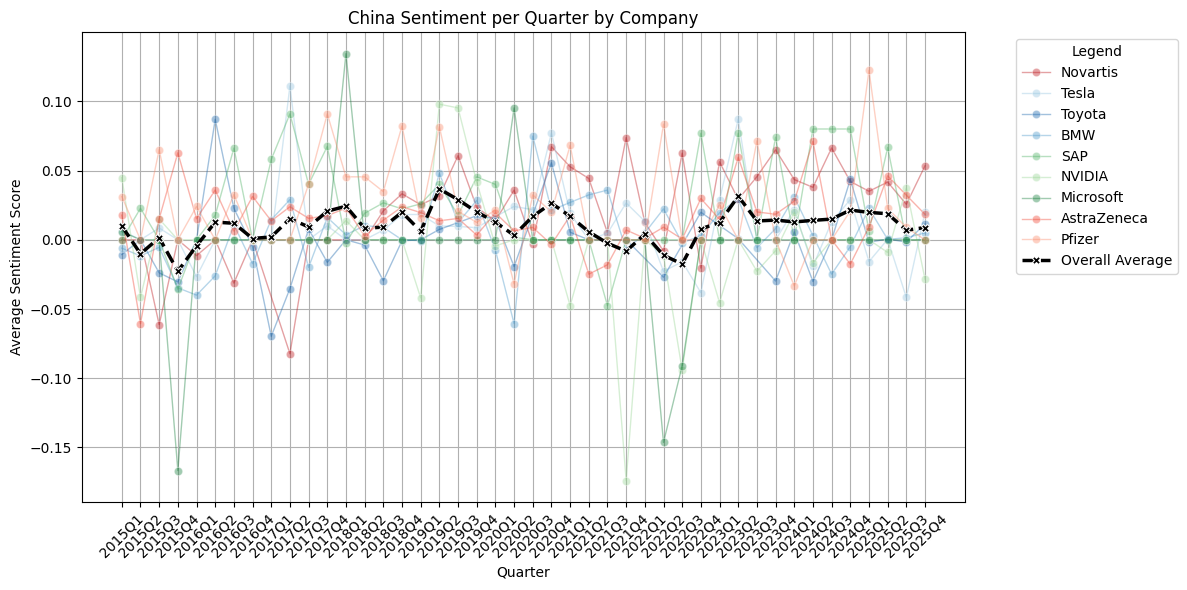

In [120]:
# Define the industry base color palettes
industry_palettes = {
    'Autos': 'Blues',
    'Healthcare': 'Reds',
    'Tech': 'Greens'
}

company_color_map = {}

# Group companies by their industry to assign sequential shades
# Using the original df_sentiment to ensure all companies are captured
industry_company_groups = df_sentiment.groupby('industry')['company'].unique()

for industry, companies_in_industry in industry_company_groups.items():
    if industry in industry_palettes:
        palette_name = industry_palettes[industry]
        num_companies = len(companies_in_industry)

        # Generate a color palette with enough distinct shades
        # Using num_companies + 1 and slicing [1:] to avoid the lightest shade if desired,
        # or simply num_companies if a wider range is needed.
        # Ensuring at least 2 shades if there's only one company to make the palette generation consistent
        colors = sns.color_palette(palette_name, n_colors=max(num_companies + 1, 3))[1:]

        for i, company in enumerate(companies_in_industry):
            company_color_map[company] = colors[i]
    else:
        # Handle 'Other' category or unmapped industries
        for company in companies_in_industry:
            company_color_map[company] = 'gray' # Default for 'Other'

# Sort the DataFrame by quarter to ensure the x-axis is in chronological order
df_sentiment_sorted = df_sentiment.sort_values('quarter')

# Calculate the average sentiment across all companies for each quarter
average_trend = df_sentiment_sorted.groupby('quarter')['avgsentiment'].mean().reset_index()

plt.figure(figsize=(12, 6))

# Plot individual company lines with transparency, using the new color map
sns.lineplot(data=df_sentiment_sorted, x='quarter', y='avgsentiment', hue='company', marker='o', alpha=0.4, palette=company_color_map, linewidth=1)

# Plot the overall average trendline
# We use a distinct color (black) and style (dashed) to distinguish it
sns.lineplot(data=average_trend, x='quarter', y='avgsentiment',
             color='black', linestyle='--', linewidth=2.5, label='Overall Average', marker='X')

plt.title('China Sentiment per Quarter by Company')
plt.xlabel('Quarter')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)

# Update legend to include the new line and move it outside the plot
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [74]:
df_industry_quarter_sentiment = df_sentiment.groupby(['industry', 'quarter'])['avgsentiment'].mean().reset_index()

print("Average sentiment grouped by industry and quarter:")
display(df_industry_quarter_sentiment.head())

Average sentiment grouped by industry and quarter:


,industry,quarter,avgsentiment
0,Autos,2015Q1,-0.010824
1,Autos,2015Q2,-0.024633
2,Autos,2015Q3,-0.034106
3,Autos,2015Q4,-0.056953
4,Autos,2016Q1,-0.048889


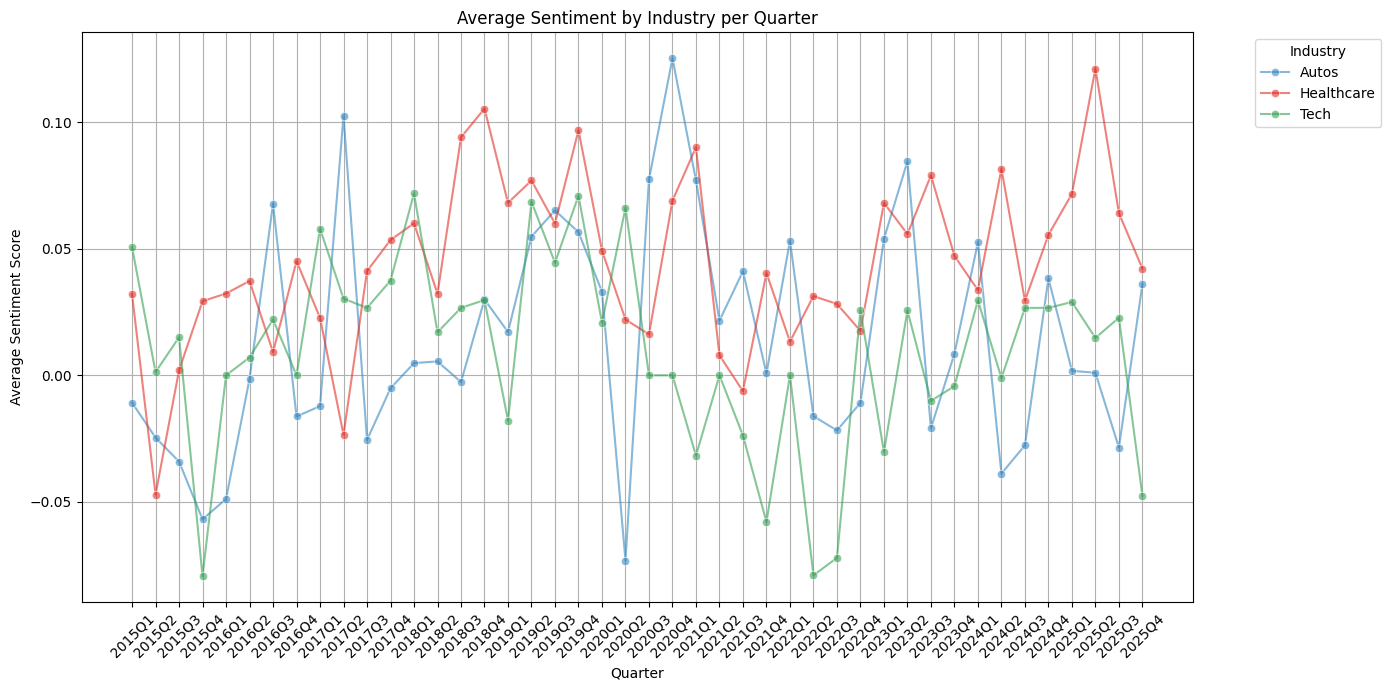

In [117]:
# Define the industry base color palettes (assuming these are consistent with the cell above)
industry_palettes = {
    'Autos': 'Blues',
    'Healthcare': 'Reds',
    'Tech': 'Greens'
}

# Generate distinct colors for each industry from their respective palettes
industry_plot_colors = {}
for industry, palette_name in industry_palettes.items():
    # Pick a distinct, darker shade from the palette for industry averages
    industry_plot_colors[industry] = sns.color_palette(palette_name, 5)[3] # e.g., 4th color from a 5-color palette

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_industry_quarter_sentiment, x='quarter', y='avgsentiment', hue='industry', marker='o',
             palette=industry_plot_colors, linewidth=1.5, alpha=0.6) # Added alpha=0.8 here

plt.title('Average Sentiment by Industry per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

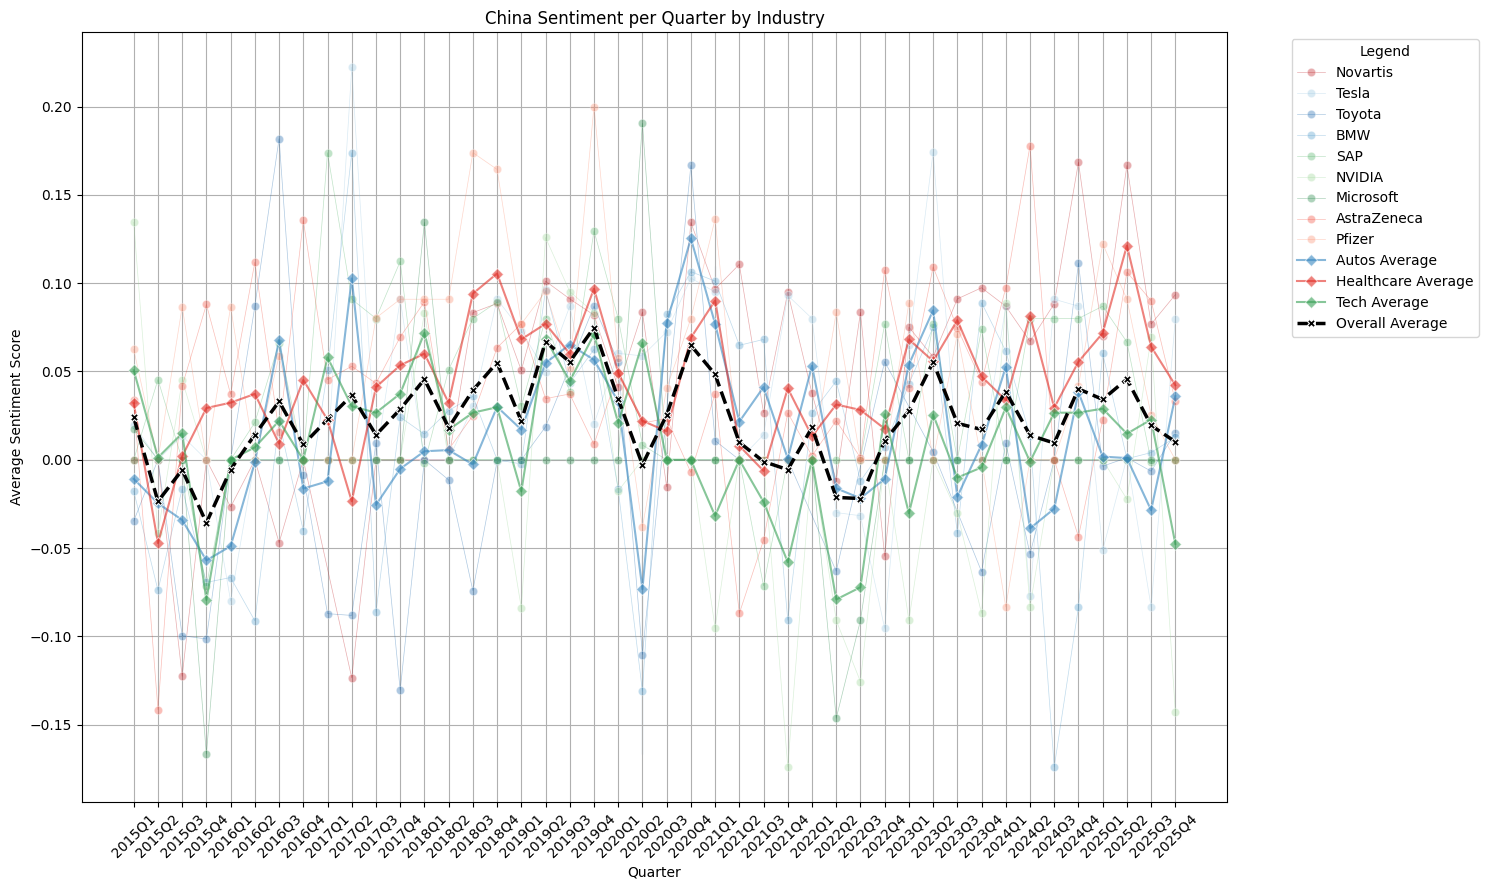

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Re-consolidate Color and Data Preparation ---
# Define the industry base color palettes
industry_palettes = {
    'Autos': 'Blues',
    'Healthcare': 'Reds',
    'Tech': 'Greens'
}

# Generate company-specific colors using industry palettes
company_color_map = {}
industry_company_groups = df_sentiment.groupby('industry')['company'].unique()

for industry, companies_in_industry in industry_company_groups.items():
    if industry in industry_palettes:
        palette_name = industry_palettes[industry]
        num_companies = len(companies_in_industry)
        # Ensure enough distinct shades, avoiding the lightest one often used for background
        colors = sns.color_palette(palette_name, n_colors=max(num_companies + 1, 3))[1:]
        for i, company in enumerate(companies_in_industry):
            company_color_map[company] = colors[i]
    else:
        # Default for 'Other' industries
        for company in companies_in_industry:
            company_color_map[company] = 'gray'

# Generate distinct colors for each industry from their respective palettes (for industry average lines)
industry_plot_colors = {}
for industry, palette_name in industry_palettes.items():
    industry_plot_colors[industry] = sns.color_palette(palette_name, 5)[3] # Pick a darker shade

# --- Combined Plotting ---
plt.figure(figsize=(15, 9))

# 1. Plot individual company sentiment lines (from the first chart)
sns.lineplot(data=df_sentiment_sorted, x='quarter', y='avgsentiment', hue='company', marker='o',
             alpha=0.35, palette=company_color_map, linewidth=0.5)

# 2. Plot industry average sentiment lines (from the second chart)
# Iterate to assign individual labels for the legend
for industry in df_industry_quarter_sentiment['industry'].unique():
    industry_df = df_industry_quarter_sentiment[df_industry_quarter_sentiment['industry'] == industry]
    sns.lineplot(data=industry_df, x='quarter', y='avgsentiment',
                 color=industry_plot_colors[industry], linestyle='-', linewidth=1.5, alpha=0.6,
                 label=f'{industry} Average', marker='D')

# 3. Plot the overall average trendline (from the first chart)
sns.lineplot(data=average_trend, x='quarter', y='avgsentiment',
             color='black', linestyle='--', linewidth=2.5, label='Overall Average', marker='X')

plt.title('China Sentiment per Quarter by Industry')
plt.xlabel('Quarter')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)

# Adjust legend to accommodate all entries
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

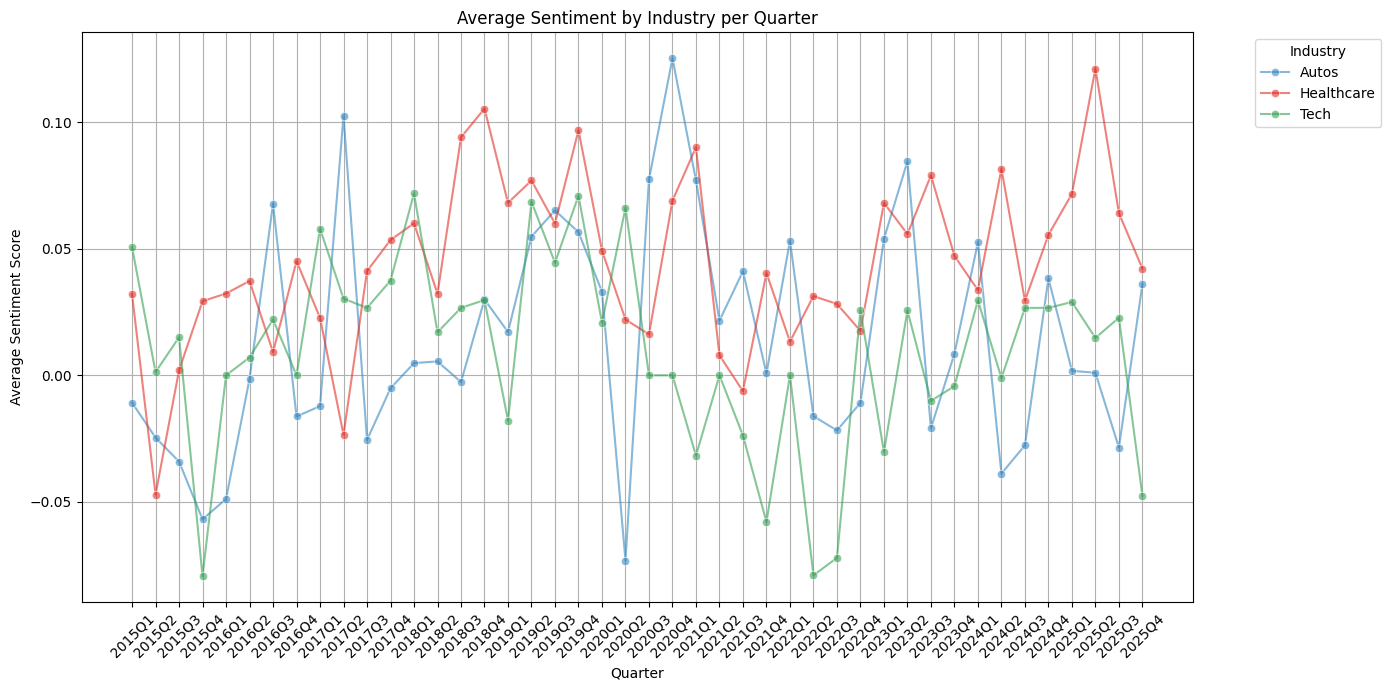

In [121]:
# Define the industry base color palettes (assuming these are consistent with the cell above)
industry_palettes = {
    'Autos': 'Blues',
    'Healthcare': 'Reds',
    'Tech': 'Greens'
}

# Generate distinct colors for each industry from their respective palettes
industry_plot_colors = {}
for industry, palette_name in industry_palettes.items():
    # Pick a distinct, darker shade from the palette for industry averages
    industry_plot_colors[industry] = sns.color_palette(palette_name, 5)[3] # e.g., 4th color from a 5-color palette

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_industry_quarter_sentiment, x='quarter', y='avgsentiment', hue='industry', marker='o',
             palette=industry_plot_colors, linewidth=1.5, alpha=0.6) # Added alpha=0.8 here

plt.title('Average Sentiment by Industry per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

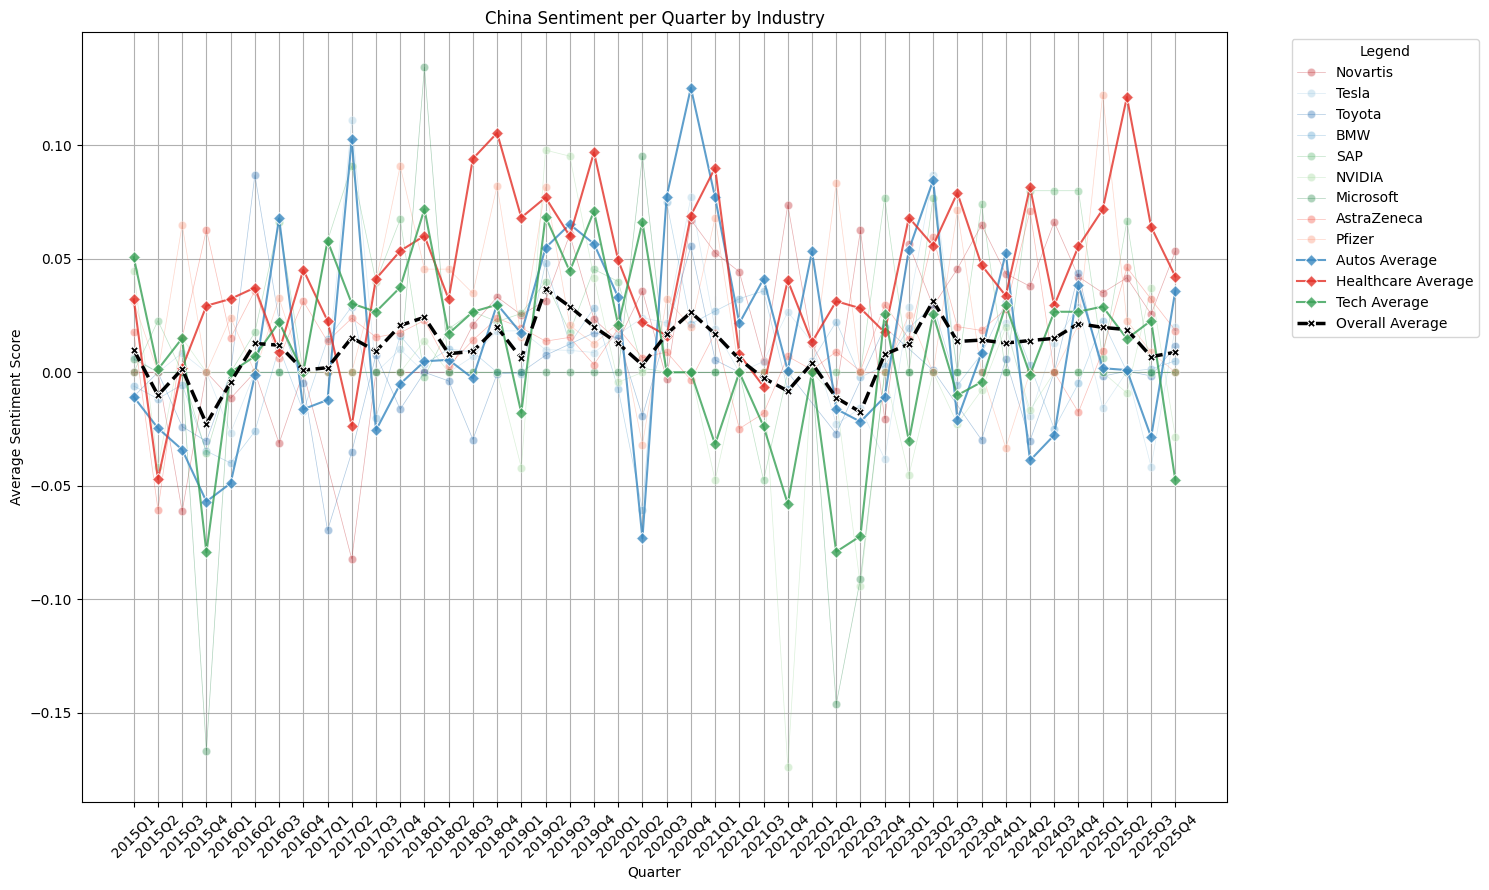

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Re-consolidate Color and Data Preparation ---
# Define the industry base color palettes
industry_palettes = {
    'Autos': 'Blues',
    'Healthcare': 'Reds',
    'Tech': 'Greens'
}

# Generate company-specific colors using industry palettes
company_color_map = {}
industry_company_groups = df_sentiment.groupby('industry')['company'].unique()

for industry, companies_in_industry in industry_company_groups.items():
    if industry in industry_palettes:
        palette_name = industry_palettes[industry]
        num_companies = len(companies_in_industry)
        # Ensure enough distinct shades, avoiding the lightest one often used for background
        colors = sns.color_palette(palette_name, n_colors=max(num_companies + 1, 3))[1:]
        for i, company in enumerate(companies_in_industry):
            company_color_map[company] = colors[i]
    else:
        # Default for 'Other' industries
        for company in companies_in_industry:
            company_color_map[company] = 'gray'

# Generate distinct colors for each industry from their respective palettes (for industry average lines)
industry_plot_colors = {}
for industry, palette_name in industry_palettes.items():
    industry_plot_colors[industry] = sns.color_palette(palette_name, 5)[3] # Pick a darker shade

# --- Combined Plotting ---
plt.figure(figsize=(15, 9))

# 1. Plot individual company sentiment lines (from the first chart)
sns.lineplot(data=df_sentiment_sorted, x='quarter', y='avgsentiment', hue='company', marker='o',
             alpha=0.35, palette=company_color_map, linewidth=0.5)

# 2. Plot industry average sentiment lines (from the second chart)
# Iterate to assign individual labels for the legend
for industry in df_industry_quarter_sentiment['industry'].unique():
    industry_df = df_industry_quarter_sentiment[df_industry_quarter_sentiment['industry'] == industry]
    sns.lineplot(data=industry_df, x='quarter', y='avgsentiment',
                 color=industry_plot_colors[industry], linestyle='-', linewidth=1.5, alpha=0.8,
                 label=f'{industry} Average', marker='D')

# 3. Plot the overall average trendline (from the first chart)
sns.lineplot(data=average_trend, x='quarter', y='avgsentiment',
             color='black', linestyle='--', linewidth=2.5, label='Overall Average', marker='X')

plt.title('China Sentiment per Quarter by Industry')
plt.xlabel('Quarter')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)

# Adjust legend to accommodate all entries
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()